# 10. Quantenkryptografie

Bei der Quantenkryptografie geht es darum, einen durch quantenmechanischen Zufall erzeugten Schlüssel zu erzeugen und diesen anschliessend **abhörsicher** von einem Ort (A bzw. Alice) zu einem anderen Ort (B bzw. Bob) zu übertragen. Das Verfahren ist im Buch in Kap. 18.3 (S.203) erklärt und die Umsetzung mit Qiskit finden Sie in Kap. 20.2 (S. 244).

Hier gehen wir das Protokoll BB84 noch einmal schrittweise durch. Mit den vorgestellten Programmen können Sie den Algorithmus testen und mit ihm experimentieren.

## Inhalt

1. <a href="Kryptografie.ipynb#bb84">Erklärung des Protokolls BB84</a>
    
2. [Automatisiertes Programm](#autop)    
    
3. [Übertragung wird abgehört](#erwpr)
    
4. [Fazit, Schlussfolgerungen](#fazit)

5. [Weiterführendes Projekt](#projekt)



<a name="bb84"></a>

### 1. Erklärung des Protokolls BB84

Zuerst laden wir die benötigten Module aus der Qiskit Programmbibliothek:

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, BasicAer
from qiskit.providers.aer import QasmSimulator
from numpy import pi

Für den Quantenschaltkreis benötigen wir zwei Qubits und zwei klassische Register mit jeweils zwei Bit. Wir Arbeiten mit einem Simulator, deshalb wählen wir als Backend den `qasm_simulator`:

In [2]:
qr = QuantumRegister(2, 'q')
cra = ClassicalRegister(2, 'Alice')
crb = ClassicalRegister(2, 'Bob')
backend = BasicAer.get_backend('qasm_simulator')
circuit = QuantumCircuit(qr, cra, crb)

Schauen Sie sich den Quantenschaltkreis in Abb. 18.5 auf S. 206 im Buch an. Er ist in die Seite der Senderin (Alice) und die Seite des Empfängers (Bob) aufgeteilt. Schauen wir uns aber zuerst an, was Allice machen muss:

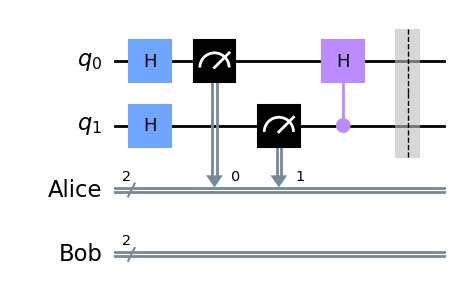

In [3]:
#--- Alice ------------------------------
circuit.h(qr[0])
circuit.h(qr[1])
circuit.measure(qr[0], cra[0])
circuit.measure(qr[1], cra[1])
circuit.ch(qr[1], qr[0])
circuit.barrier()
#----------------------------------------

circuit.draw('mpl')

Sie muss einerseits ein Zufallsbit erzeugen. Dazu benutzt sie Qubit $q_0$ mit der Sequenz $H$, $M$ als quantenmechanischen Zufallsgenerator. Das Qubit $q_0$ befindet sich jetzt entweder im Zustand $|0\rangle$ oder $|1\rangle$. Der Zustand dieses Qubits ist im Buch in Abb. 18.5 mit $a$ bezeichnet. Andererseits muss Alice auch festlegen in welcher Basis das Qubit $q_0$ übertragen wird. Dies bewerkstelligt sie mit Qubit $q_1$. Auch hier wird die Sequenz $H$, $M$ als quantenmechanischer Zufallsgenerator verwendet. Danach befindet sich auch Qubit $q_1$ entweder im Zustand $|0\rangle$ oder $|1\rangle$. Dieser Zustand ist im Buch in Abb. 18.5 mit $a'$ bezeichnet.

Schliesslich setzt Sie ein controlled $H$ (`ch`). Dies ist ein Zwei-Qubit Gate, ähnlich wie $CNOT$. Es wirkt auf Qubit $q_0$ in Abhängigkeit des Zustands von $q_1$: Ist $a'=|0\rangle$, passiert nichts. Das Qubit $q_0$ bleibt im Zustand $a$ (also entweder $|0\rangle$ oder $|1\rangle$). Ist hingegen $a'=|1\rangle$, wirkt $H$ auf $q_0$ und versetzt dieses entweder in den Zustand $|+\rangle=\frac{1}{\sqrt{2}}|0\rangle+\tfrac{1}{\sqrt{2}}|1\rangle$ oder den Zustand $|-\rangle=\tfrac{1}{\sqrt{2}}|0\rangle-\tfrac{1}{\sqrt{2}}|1\rangle$.

Wir sagen, das Qubit $q_0$ werde entweder in der Basis ($0$,$1$) oder in der Basis ($+$,$-$) übertragen. Auch diese Wahl der Basis erfolgt rein zufällig. Anschliessend wird das Qubit $q_0$ als $|x\rangle$ auf die Reise zu Bob geschickt.


Betrachten wir jetzt die **Seite von Bob**: Bob empfängt das Qubit $|x\rangle$ von Alice. Damit er Informationen daraus ziehen kann, muss er es messen. Auch Bob nutzt sein Qubit $q_0$ um seine Messbasis festzulegen. Mit dem Zufallsgenerator auf $q_1$ erzeugt er ein Zufallsbit, das entweder den Wert $0$ oder $1$ enthält. Aufgrund dieses Wertes wird die Messbasis mithilfe des `cH`-Gates (controlled $H$) auf ($0$,$1$) oder auf ($+$,$-$) festgelegt. Die Anweisungen dazu sehen Sie unten. Der Reset von $q_1$ ist hier notwendig, damit wir die ganze Ablaufkette in einem Durchlauf erledigen können. Abschliessend wird der Schaltkreis mit der MatPlotLib schön gezeichnet.

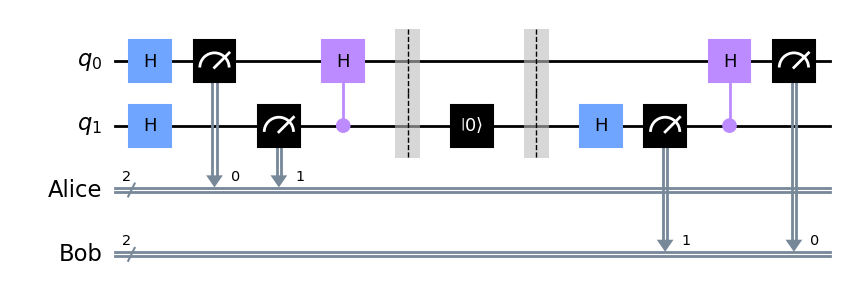

In [4]:
circuit.reset(qr[1])

#--- Bob --------------------------------
circuit.barrier()
circuit.h(qr[1])
circuit.measure(qr[1], crb[1])
circuit.ch(qr[1], qr[0])
circuit.measure(qr[0], crb[0])
#----------------------------------------

circuit.draw('mpl')

Dieser Schaltkreis muss so oft durchlaufen werden, bis die Länge des gewünschten Schlüssels sicher erreicht ist. Schauen wir uns aber zunächst einmal das Ergebnis eines Durchlaufs an:

In [5]:
result = execute(circuit, backend, shots=1).result().get_counts()
print (result)

{'01 10': 1}


Das Ergebnis wird als Zeichenkette (String) ausgegeben. Es hätte auch z. B.  `{'10 01': 1}` sein können. Nehmen wir dieses Beispiel zur Erklärung der Bedeutung der Werte. 

Die $1$ nach dem Doppelpunkt besagt, dass dies das Ergebnis nach einem Durchlauf (Shot) ist. Die Zeichenkette `01 10` enthält die Messwerte, die in den klassischen Registern `a` und `b` gespeichert sind in der Reiehfolge `a b`. Beide haben wir als klassische zwei-Bit Register definiert, erkennbar jeweils an der `2` am Anfang der Linie. Auch hier wird die in Qiskit übliche Bitreihenfolge von rechts nach links eingehalten. So bedeutet $a=01$, dass der Messwert von $q_0=1$ und der Messwert von $q_1=0$ war. Analog bei Bob: $b=10$ bedeutet, dass der Messwert von $q_0=0$ und der Messwert von $q_1=1$ war.

In der Nomenklatur von Abb 18.5 und der Tabelle von Abb. 18.6 bzw. Tabelle 20.1 entspricht das: `{a'a b'b: 1}`. 

Um nun einen gültigen Schlüssel zu erzeugen, muss der ganze Schaltkreis mehrere Male durchlaufen werden. Nach jedem Durchlauf müssen die Messwerte von Alice und Bob in einer Tabelle aufgelistet werden, so wie in Tabelle 20.1 im Buch. Immer dann, wenn $a'=b'$ ist, stimmen auch die Werte $a$ und $b$ überein und das mit Sicherheit. Alice und Bob können diese Werte anschliessend in ihren Schlüssel übernehmen. Die ggf. anderen Übereinstimmungen sind Zufällig und werden verworfen.

Die $a'$- und $b'$-Werte entsprechen der Einstellung der jeweiligen Übertragungs-Basis bei Alice und bei Bob. Dabei entspricht der Wert $0$ jeweils der Standard-Basis $(0,1)$ und der Wert $1$ der um $45$° gedrehten Basis $(+, -)$. Falls die beiden Basen übereinstimmen ($a'=b'$), sind  die Messergebnisse $a$ und  $b$ gleich. Das erkennt man auch in der Tabelle 20.1, auf S. 247 sofort. Stimmen die Basen nicht überein, ist das Messergebnis von Bob zufällig, die Qubits können übereinstimmen oder auch nicht. Diese Bits werden verworfen.

Alice muss nun ihre $a'$-Werte als Zeichenkette an Bob übermitteln. Bob seinerseits schickt seine $b'$-Werte an Alice. Dies kann per Telefon, per E-Mail oder sonst irgendwie geschehen. Nun können beide aus der Liste ihrer gesendeten bzw. der empfangenen Qubit-Werte den Schlüssel extrahieren. Sie nehmen beide nur diejenigen $a$- bzw. $b$-Werte in ihren Schlüssel auf, bei denen $a'=b'$ gilt. 

Ist ein längerer Schlüssel gewünscht, müssen mehr Durchläufe gemacht werden. Im Mittel werden etwa die Hälfte der Durchläufe ein gültiges Schlüsselbit liefern. 

In unserem Notebook könnten wir in der `execute`-Anweisung die Anzahl Shots auf einen beliebigen, ganzzahligen Wert setzen. So gab die Funktion z. B. für `shots=16` das folgende Resultat:

`{'10 10':1,'11 11':3,'01 01':4,'11 01':4,'10 00':1,'00 00':1,'11 00':2}`

Die Zahlen nach dem Doppelpunkt geben die jeweiligen Häufigkeiten an, mit denen das davor stehende Resultat aufgetreten ist. In unserem Beispiel ist die Summe dieser Häufigkeiten natürlich $16$, und wir sehen, dass hier in $9$ Fällen ein gültiges Schlüsselbit dabei war. Allerdings können wir aus dieser Darstellung die Reihenfolge nicht mehr rekonstruieren. Deshalb nützt uns die Heraufsetzung des `shots`-Wertes hier nicht bei der Erstellung eines Schlüssels. Wir müssen für jedes Bit das Notebook erneut durchlaufen lassen.


<a name="autop"></a>

### 2. Automatisiertes Programm

Wir erweitern das Programm durch eine `for`-Schleife. Mit dem Parameter `n`  können Sie einstellen, wie oft der Schaltkreis durchlaufen werden soll. Die ersten beiden Zellen müssen mindestens einmal durchlaufen werden. In der dritten Zelle können Sie die Anzahl `n` der Durchläufe wählen und diese beliebig oft durchlaufen lassen..

Das Programm gibt jeden Zwischenschritt, mit den im Buch in Kap. 20.2 auf S. 247, verwendeten Parametern `a'`, `a`, `b'`, `b` an. Am Ende werden die Schlüssel von Alice und Bob zum Vergleich übereinander ausgedruckt.


In [11]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, BasicAer
from qiskit.providers.aer import QasmSimulator
from numpy import pi

In [12]:
qr = QuantumRegister(2, 'q')
cra = ClassicalRegister(2, 'a')
crb = ClassicalRegister(2, 'b')
backend = BasicAer.get_backend('qasm_simulator')
circuit = QuantumCircuit(qr, cra, crb)

In [13]:
n=25 # Hier wählen Sie die Anzahl durchläufe
print()
print ('Tabelle der Resultate nach ', n, ' Durchläufen:')         
print()
key1=''
key2=''
i=0
ind='  '
for x in range(1,n+1):
    i=i+1
#--- Alice ------------------------------
    circuit.h(qr[0])
    circuit.h(qr[1])
    circuit.measure(qr[0], cra[0])
    circuit.measure(qr[1], cra[1])
    circuit.ch(qr[1], qr[0])
    circuit.barrier()
#----------------------------------------
    
    circuit.reset(qr[1])
    
#--- Bob --------------------------------
    circuit.barrier()
    circuit.h(qr[1])
    circuit.measure(qr[1], crb[1])
    circuit.ch(qr[1], qr[0])
    circuit.measure(qr[0], crb[0])
#----------------------------------------
    result = execute(circuit, backend, shots=1).result().get_counts()
    dg=str(result)
    if i>9: ind=' '
    if i>99: ind=''
    print (ind, i ,"." , "Durchlauf:   ", dg + ":     a' = " + dg[2]+ "  " + "a = "+ dg[3]+ "     " + "b' = "+ dg[5] +"  "+ "b = "+ dg[6])
    if dg[2]==dg[5]:
        key1=key1+dg[3]
        key2=key2+dg[6]

print()
print ('Nun berechnen wir die Schlüssel, die Alice und Bob extrahiert haben:')
print()
print ("Der Schlüssel von Alice ist: " + key1)
print ("Der Schlüssel von Bob ist  : " + key2)
print ()
print ('Ist alles gut gelaufen, stimmen die beiden Schlüssel überein.')
print ()


Tabelle der Resultate nach  25  Durchläufen:

   1 . Durchlauf:    {'01 01': 1}:     a' = 0  a = 1     b' = 0  b = 1
   2 . Durchlauf:    {'10 10': 1}:     a' = 1  a = 0     b' = 1  b = 0
   3 . Durchlauf:    {'01 10': 1}:     a' = 0  a = 1     b' = 1  b = 0
   4 . Durchlauf:    {'10 10': 1}:     a' = 1  a = 0     b' = 1  b = 0
   5 . Durchlauf:    {'01 10': 1}:     a' = 0  a = 1     b' = 1  b = 0
   6 . Durchlauf:    {'11 01': 1}:     a' = 1  a = 1     b' = 0  b = 1
   7 . Durchlauf:    {'11 11': 1}:     a' = 1  a = 1     b' = 1  b = 1
   8 . Durchlauf:    {'01 10': 1}:     a' = 0  a = 1     b' = 1  b = 0
   9 . Durchlauf:    {'11 11': 1}:     a' = 1  a = 1     b' = 1  b = 1
  10 . Durchlauf:    {'00 00': 1}:     a' = 0  a = 0     b' = 0  b = 0
  11 . Durchlauf:    {'00 10': 1}:     a' = 0  a = 0     b' = 1  b = 0
  12 . Durchlauf:    {'00 11': 1}:     a' = 0  a = 0     b' = 1  b = 1
  13 . Durchlauf:    {'10 10': 1}:     a' = 1  a = 0     b' = 1  b = 0
  14 . Durchlauf:    {'11 00':

<a id='erwpr'></a>
### 3. Die Übertragung wird abgehört

Nun wollen wir untersuchen, was geschieht, wenn die übertragenen Qubits $|x\rangle$ von einem Lauscher bzw. einer Lauscherin (Eve) abgehört werden. Dieser Vorgang entspricht einer **Messung**. Dazu müssen wir ein neues klassisches Einbit-Register `cre = ClassicalRegister(1, 'eve')` einführen, in dem die Messwerte von Eve abgespeichert werden. Zusätzlich müssen wir eine Messung zwischen Alice und Bob einfügen. Ansonsten ändern wir nichts am Schaltkreis.

In [14]:
qr = QuantumRegister(2, 'q')
cra = ClassicalRegister(2, 'a')
crb = ClassicalRegister(2, 'b')
cre = ClassicalRegister(1, 'Eve')
backend = BasicAer.get_backend('qasm_simulator')
circuit = QuantumCircuit(qr, cra, crb, cre)

In [15]:
n=25 # Hier wählen Sie die Anzahl durchläufe
print()
print ('Tabelle der Resultate nach ', n, ' Durchläufen:')         
print()
key1=''
key2=''
key3=''
i=0
ind='  '
for x in range(1,n+1):
    i=i+1
#--- Alice ------------------------------
    circuit.h(qr[0])
    circuit.h(qr[1])
    circuit.measure(qr[0], cra[0])
    circuit.measure(qr[1], cra[1])
    circuit.ch(qr[1], qr[0])
    circuit.barrier()
#----------------------------------------
    
#--- Eve hört mit -----------------------
    circuit.measure(qr[0], cre)
    
    circuit.reset(qr[1])

#--- Bob --------------------------------
    circuit.barrier()
    circuit.h(qr[1])
    circuit.measure(qr[1], crb[1])
    circuit.ch(qr[1], qr[0])
    circuit.measure(qr[0], crb[0])
#----------------------------------------
    result = execute(circuit, backend, shots=1).result().get_counts()
    dg=str(result)
    if i>9: ind=' '
    if i>99: ind=''
    print (ind, i ,"." , "Durchlauf:   ", dg + ":     a' = " + dg[4]+ "  " + "a = "+ dg[5]+ "     " + "b' = "+ dg[7] +"  "+ "b = "+ dg[8])
    if dg[4]==dg[7]:
        key1=key1+dg[5]
        key2=key2+dg[8]
    key3=key3+dg[2]

print()
print ('Nun berechnen wir die Schlüssel, die Alice und Bob extrahiert haben:')
print()
print ("Der Schlüssel von Alice ist : " + key1)
print ("Der Schlüssel von Bob ist   : " + key2)
print ("Die Messwerte von Eve sind  : " + key3)
print ()
print ('Die beiden Schlüssel stimmen jetzt nicht mehr überein!')
print ()


Tabelle der Resultate nach  25  Durchläufen:

   1 . Durchlauf:    {'0 00 00': 1}:     a' = 0  a = 0     b' = 0  b = 0
   2 . Durchlauf:    {'0 10 00': 1}:     a' = 1  a = 0     b' = 0  b = 0
   3 . Durchlauf:    {'0 11 10': 1}:     a' = 1  a = 1     b' = 1  b = 0
   4 . Durchlauf:    {'0 00 00': 1}:     a' = 0  a = 0     b' = 0  b = 0
   5 . Durchlauf:    {'1 11 01': 1}:     a' = 1  a = 1     b' = 0  b = 1
   6 . Durchlauf:    {'1 01 01': 1}:     a' = 0  a = 1     b' = 0  b = 1
   7 . Durchlauf:    {'0 11 00': 1}:     a' = 1  a = 1     b' = 0  b = 0
   8 . Durchlauf:    {'0 00 00': 1}:     a' = 0  a = 0     b' = 0  b = 0
   9 . Durchlauf:    {'1 10 01': 1}:     a' = 1  a = 0     b' = 0  b = 1
  10 . Durchlauf:    {'0 11 00': 1}:     a' = 1  a = 1     b' = 0  b = 0
  11 . Durchlauf:    {'1 01 01': 1}:     a' = 0  a = 1     b' = 0  b = 1
  12 . Durchlauf:    {'1 01 01': 1}:     a' = 0  a = 1     b' = 0  b = 1
  13 . Durchlauf:    {'1 01 10': 1}:     a' = 0  a = 1     b' = 1  b = 0
  14

<a id='fazit'></a>

### 4. Fazit, Schlussfolgerungen

Aufgrund der hier durchgeführten Experimente können wir Folgendes festhalten:

- Das Protokoll BB84 funktioniert. Wird die Übertragung nicht gestört (abgehört), sind die beiden Schlüssel von Alice und Bob tatsächlich immer identisch.
- Der Schlüssel ist kürzer als die Anzahl der gewählten Übertragungen. Ausserdem variiert die Länge des Schlüssels
- Wird die Übertragung abgehört, stimmen die Schlüssel von Alice und Bob nicht mehr überein. Nur bei einem zu kurz gewählten Schlüssel könnte eine zufällige Übereinstimmung auftreten.
- Aber auch wenn die beiden Schlüssel zufälligerweise identisch wären, stimmen diese nicht mit der Messsequenz von Eve überein. Eve kann mit ihrer abgehörten Bitfolge somit gar nichts anfangen.
- Es ist also von vornherein sinnlos den Übertragungskanal abzuhören. Das ist der entscheidende Vorteil der Quantenkryptografie. 

Um dennoch sicher zu sein, dass die beiden Schlüssel von Alice und Bob identisch sind, müssen Sie sich damit gegenseitig eine zuvor verabredete **Testbotschaft** verschlüsselt zuschicken. Die Möglichkeit eines direkten Vergleichs entfällt, da Sie dann den Schlüssel über einen klassischen Kanal übermitteln müssten, der wiederum unbemerkt abgehört werden könnte. 

<a id='projekt'></a>

### 5. Weiterführendes Projekt

Um ganz Sicher zu gehen, darf ein Schlüssel nur einmal verwendet werden und am besten ist er gleich lang zu wählen, wie die übermittelte Botschaft. Diese Anforderunng wird durch **One-Time-Pads** (OTP) erfüllt. Näheres dazu finden Sie [hier](https://de.wikipedia.org/wiki/One-Time-Pad).

Um mit dem BB84-Protokoll eine solche OTP-Verschlüsselung zu realisieren, muss zunächst die Bitlänge der Botschaft ermittelt werden. Danach muss der Quantenschaltkreis so oft durchlaufen werden, bis ein gültiger Schlüssel erreicht ist. Auch das kann man mit Pyton machen. Dazu ist der Klartext zuerst in eine Bitfolge umzuwandeln. Dann ist die Länge dieser Bitfolge zu ermitteln und der Schaltkreis entsprechend oft zu durchlaufen. Die Verschlüsselung erfolgt durch die bitweise Addition der Bitfolge des Klartext und jener des Schlüssels. Entschlüsselt wird der Kryptotext durch nochmaliges, bitweises addieren des Schlüssels. Falls Sie Freude am Programmieren haben, können Sie versuchen, dieses Projekt in Python umzusetzen.

Hinweise, wie dabei vorzugehen ist finden Sie z. B. [hier](https://infolab.cs.uni-saarland.de/wp-content/uploads/2020/05/Crypto.pdf).